In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
%matplotlib inline
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

%load_ext snakeviz


# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean*2      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

/Users/austin/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [370]:
#%%snakeviz
# Instantiate objects:
from precip_model import precip_model
from GLD_file_tools import GLD_file_tools
import datetime as dt
from calc_global_precip import calc_global_precip

# import cProfile
import pandas as pd


p = precip_model(database="db3.pkl", cumsum=True, mode='energy')
gld = GLD_file_tools('GLD_mount',prefix='GLD')

in_lat_grid  = np.arange(-70,70, step=0.1)
out_lat_grid = np.arange(-70,70, step=1) #np.hstack([np.arange(-80,-20,step=1), np.arange(20,80, step=1)])
out_lon_grid = np.arange(-180,180,step=1)

sim_start = dt.datetime(2015,11,1,10,45,0)
sim_stop  = dt.datetime(2015,11,2,0,0,0)

window_time = 60  # seconds
in_times = pd.date_range(start = sim_start, end = sim_stop, freq = '%ds'%window_time).tolist()


# in_time_str = "2015-11-01T10:45:00"
# in_time = dt.datetime.strptime(in_time_str,  "%Y-%m-%dT%H:%M:%S")

# flux = calc_global_precip(p, gld, in_time, 1, out_lat_grid, out_lon_grid)
print np.shape(in_lat_grid)
print np.shape(out_lat_grid)
print np.shape(p.t)

# print "Precalculating!"

# run_cmd = 'p.precalculate_gridded_values(in_lat_grid, out_lat_grid, p.t)'
# profile = cProfile.run(run_cmd)
p.precalculate_gridded_values(in_lat_grid, out_lat_grid, p.t)
# profile = cProfile.run(run_cmd)

# # Profile this fucker
# import cProfile
# import re
# %snakeviz 
print "calculating flux"
flux, flashes = calc_global_precip(p,gld, in_times[1], window_time, out_lat_grid, out_lon_grid)
# run_cmd = 'calc_global_precip(p, gld, in_time,1, out_lat_grid, out_lon_grid)'
# cProfile.run(run_cmd,'profile_precalc')




Modeling cumulative sums
(1400,)
(140,)
(90,)
Precalculating...
calculating flux
section 1
280806032
280063116


[[  3.16768069e+01  -2.57616984e+01  -7.00000000e+00   1.03977684e+02]
 [ -3.81826464e+01  -1.37369512e+02   2.00000000e+01   1.03969018e+02]
 [ -3.20569619e+01  -1.44077781e+02   5.00000000e+00   1.03946563e+02]
 ..., 
 [ -3.22057175e+01  -1.43775306e+02  -1.80000000e+01   2.42907000e-01]
 [ -3.35516037e+01  -1.42423744e+02  -7.00000000e+00   1.97306000e-01]
 [ -2.55703437e+01  -1.60942837e+02   4.00000000e+00   1.01685000e-01]]


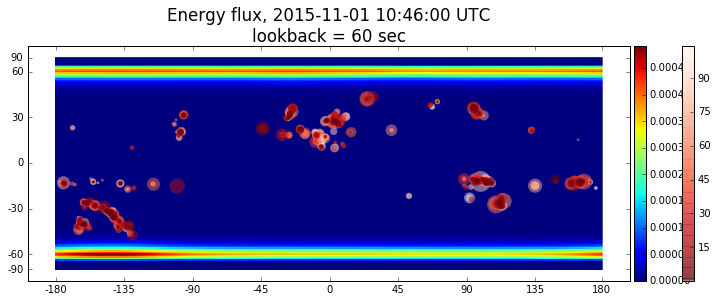

In [378]:
# Plot flux map:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from calc_global_precip import nearest_index

def plot_flux_map(flux, flashes, in_time, clims=None):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    if clims == None:
        clims = [np.min(flux), np.max(flux)]
    # Flux map
    p1  = ax1.imshow(flux, origin='lower',interpolation='None',cmap=cm.jet)
#     p1 = ax1.contourf(flux)
#     p1 = ax1.pcolor(out_lon_grid, out_lat_grid, flux)
    p1.set_clim(clims)
    fig.tight_layout()
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(p1, cax=cax)


    # Axis labels
    xticklabels = np.arange(-180,181, step=45)
    xticks = nearest_index(out_lon_grid, xticklabels)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticklabels)
    yticklabels = np.arange(-90,91, step=30)
    yticks = nearest_index(out_lat_grid, yticklabels)
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(yticklabels)

    # Flashes
    f_lat_inds = flashes[:,0] + (out_lat_grid[-1] - out_lat_grid[0])/2.0
    f_lon_inds = flashes[:,1] + (out_lon_grid[-1] - out_lon_grid[0])/2.0

    msize = abs(flashes[:,2])
    mcolor= np.clip(flashes[:,3],0,2*window_time)
    p2  = ax1.scatter(f_lon_inds,f_lat_inds, marker='o', c=mcolor,s=msize,alpha=0.5,edgecolor='None', cmap=cm.Reds_r)
    cax2 = divider.append_axes("right",size="2%",pad=0.5)
    plt.colorbar(p2,cax=cax2)

    # Title
    ax1.set_title('Energy flux, %s UTC\nlookback = %s sec'%(in_time, window_time))

plot_flux_map(flux/window_time, flashes, in_times[1])


print flashes

In [ ]:
import pstats

p = pstats.Stats('profile_precalc')
p.strip_dirs().sort_stats('tottime').print_stats()

p = pstats.Stats('profile')
p.strip_dirs().sort_stats('tottime').print_stats()

In [ ]:
scale = p.get_longitude_scaling(45, 0, out_lat_grid, out_lon_grid, I0=-10000)

plt.figure()
plt.imshow(scale, origin='lower')
print np.max(scale)
print np.min(scale)

In [ ]:
plt.imshow(flux, origin='lower')

In [ ]:
import pandas as pd

sim_start = datetime.datetime(2015,11,1,0,0,0)
sim_stop  = datetime.datetime(2015,11,2,0,0,0)

window_time = 30  # seconds

in_times = pd.date_range(start = sim_start, end = sim_stop, freq = '%ds'%window_time).tolist()

print in_times




In [7]:
print p.sc.R_E

6370000.0


In [20]:
sendbuf = dict()

for k in in_times:

    sendbuf[k.to_datetime()] = np.ones([len(in_times), len(out_lat_grid), len(out_lon_grid)])


KeyboardInterrupt: 

ERROR! Session/line number was not unique in database. History logging moved to new session 464
(49, 3)
['2015-11-01T00:00:00']
['2015-11-01T00:30:00']
['2015-11-01T01:00:00']
['2015-11-01T01:30:00']
['2015-11-01T02:00:00']
['2015-11-01T02:30:00']
['2015-11-01T03:00:00']
['2015-11-01T03:30:00']
['2015-11-01T04:00:00']
['2015-11-01T04:30:00']
['2015-11-01T05:00:00']
['2015-11-01T05:30:00']
['2015-11-01T06:00:00']
['2015-11-01T06:30:00']
['2015-11-01T07:00:00']
['2015-11-01T07:30:00']
['2015-11-01T08:00:00']
['2015-11-01T08:30:00']
['2015-11-01T09:00:00']
['2015-11-01T09:30:00']
['2015-11-01T10:00:00']
['2015-11-01T10:30:00']
['2015-11-01T11:00:00']
['2015-11-01T11:30:00']
['2015-11-01T12:00:00']
['2015-11-01T12:30:00']
['2015-11-01T13:00:00']
['2015-11-01T13:30:00']
['2015-11-01T14:00:00']
['2015-11-01T14:30:00']
['2015-11-01T15:00:00']
['2015-11-01T15:30:00']
['2015-11-01T16:00:00']
['2015-11-01T16:30:00']
['2015-11-01T17:00:00']
['2015-11-01T17:30:00']
['2015-11-01T18:00:00']
['2015-1

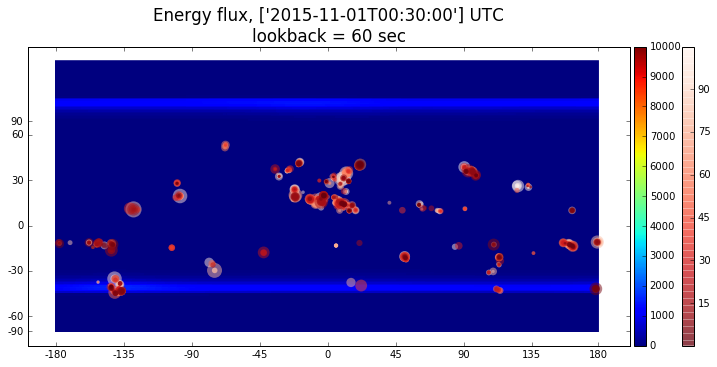

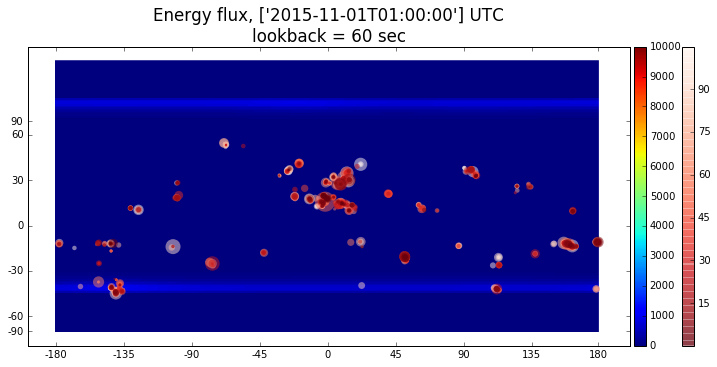

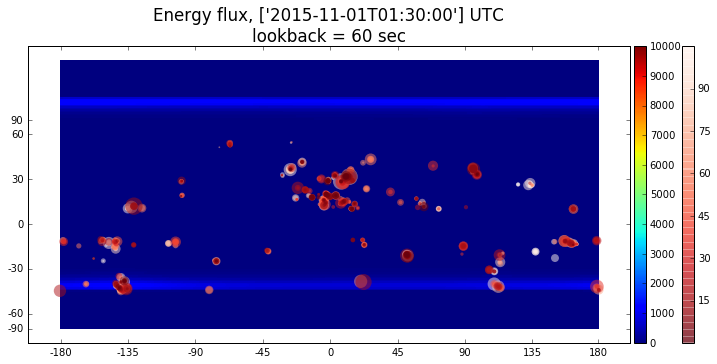

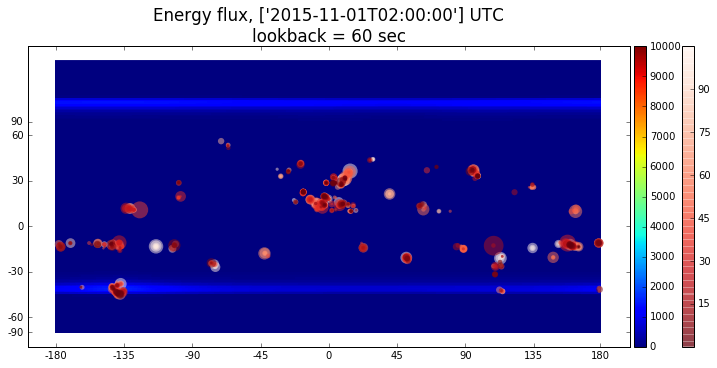

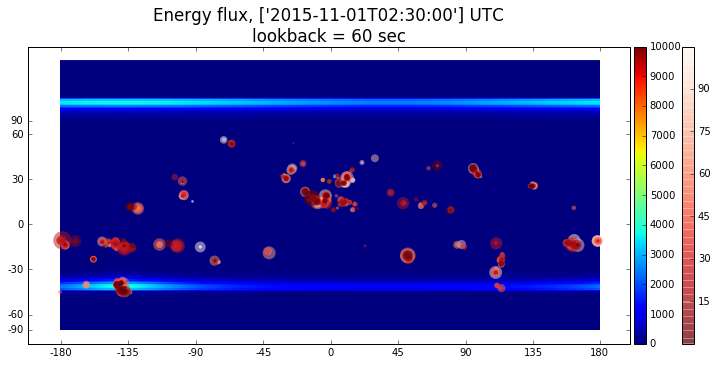

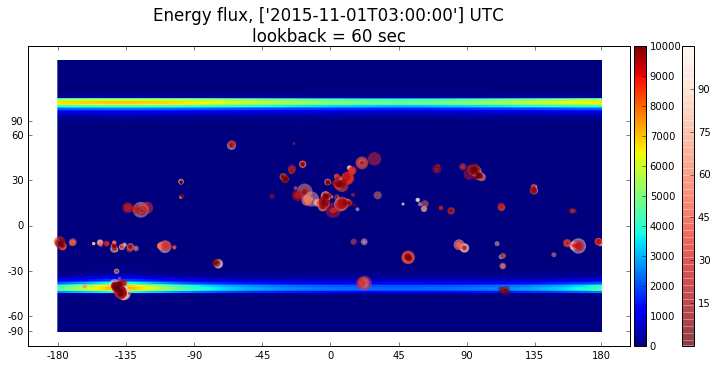

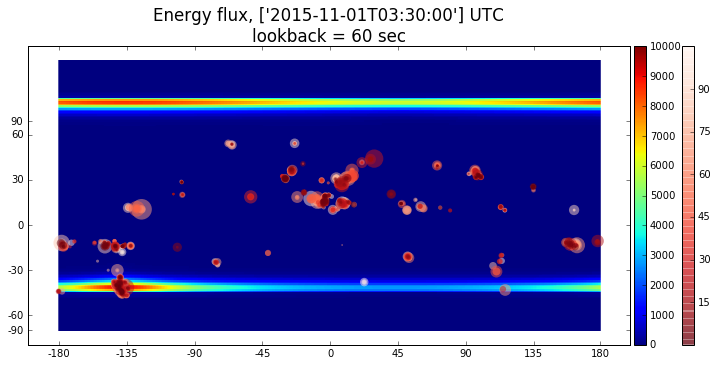

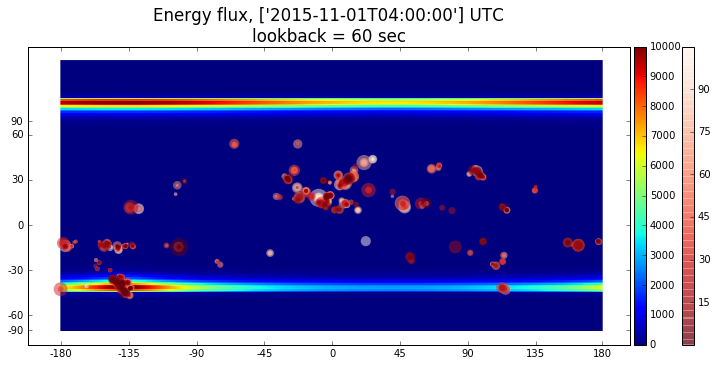

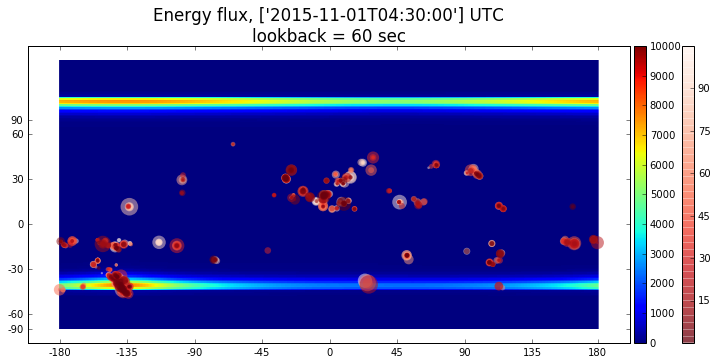

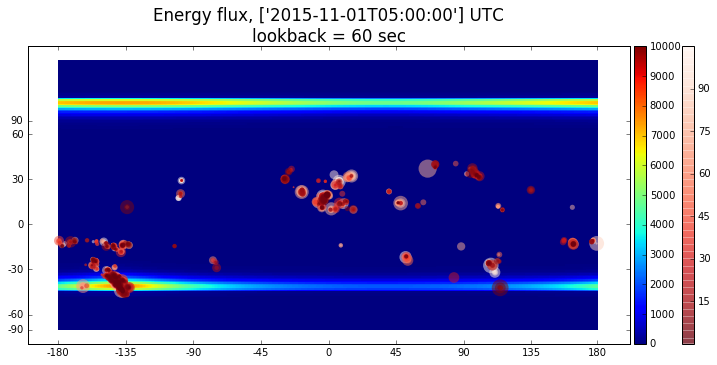

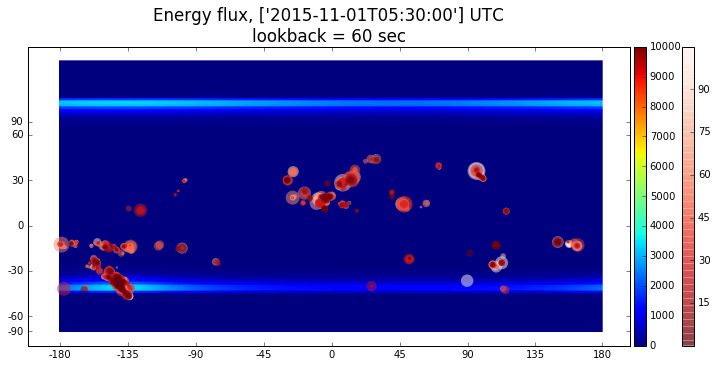

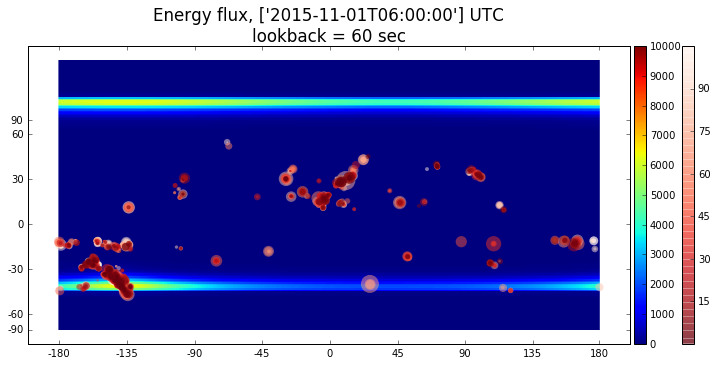

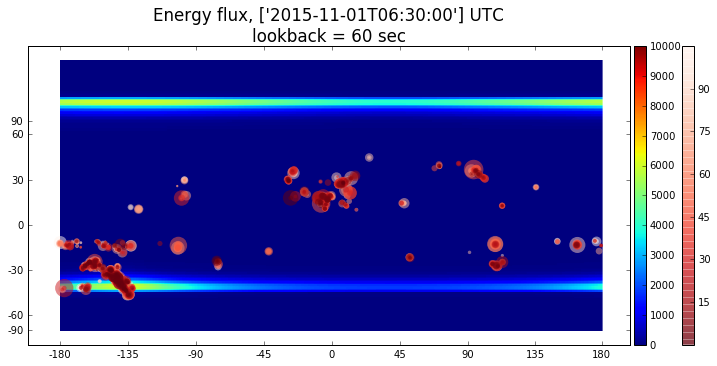

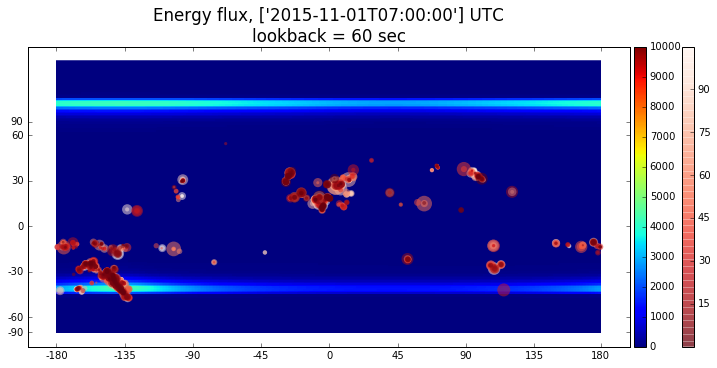

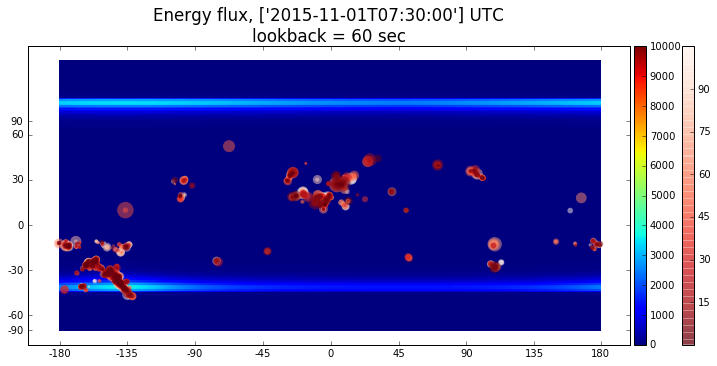

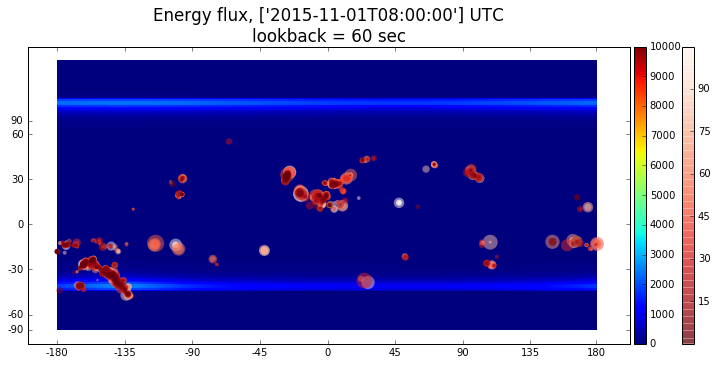

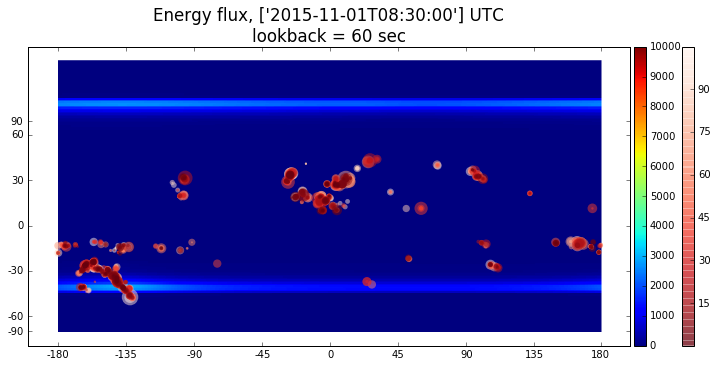

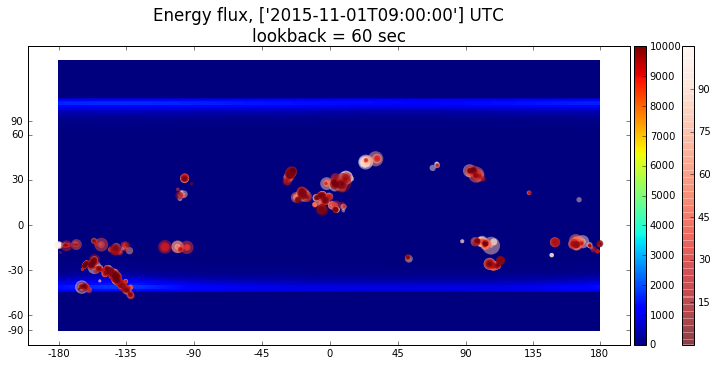

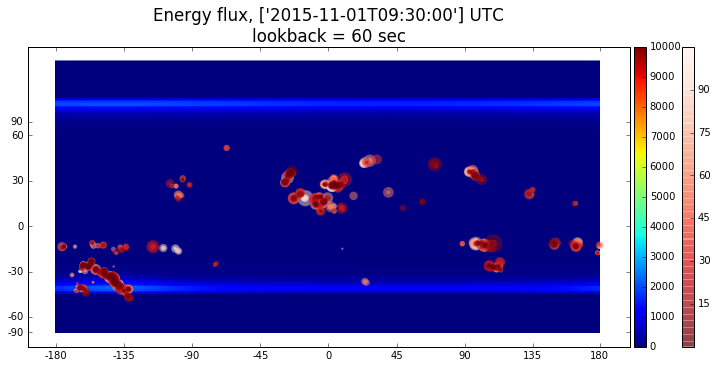

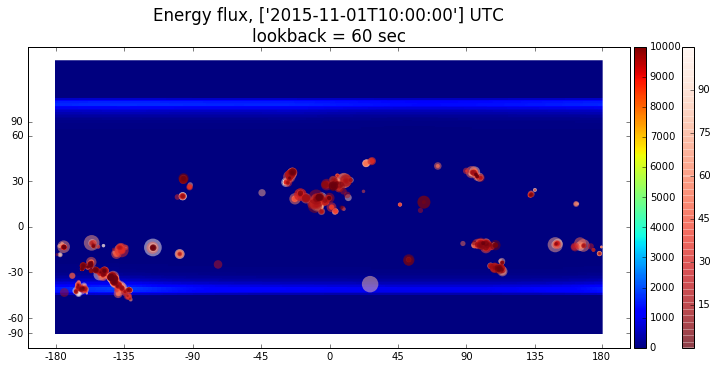

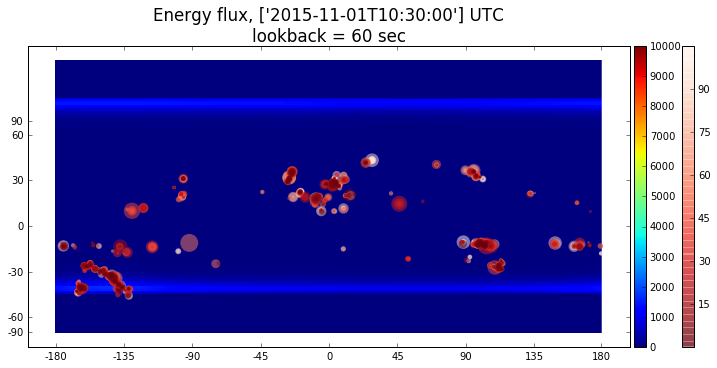

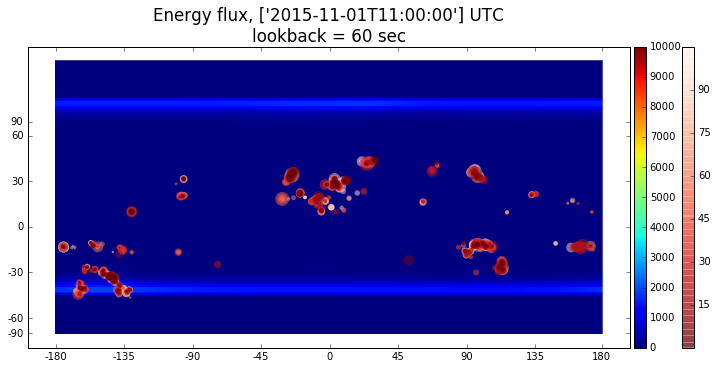

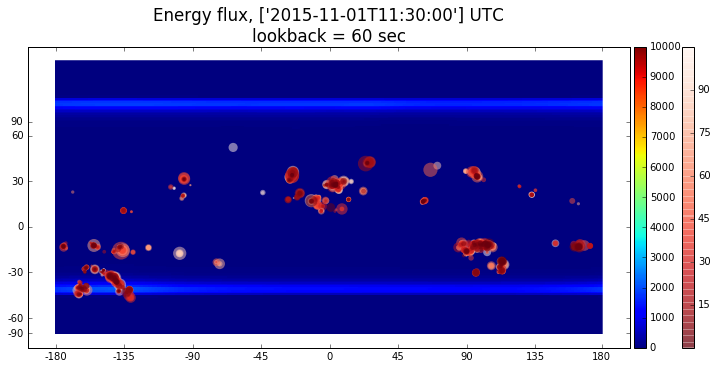

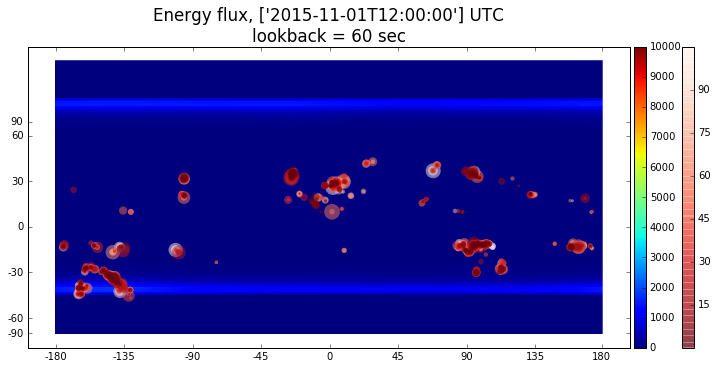

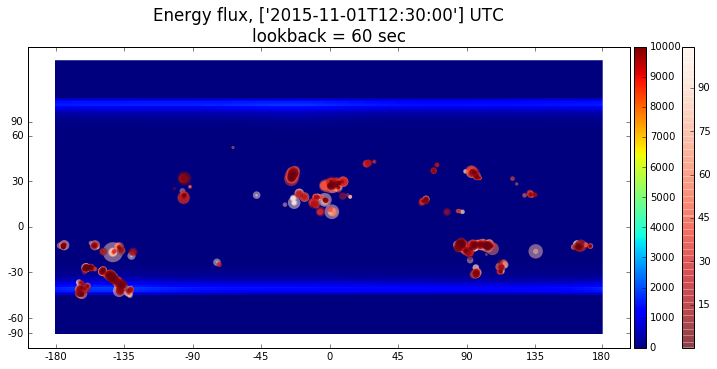

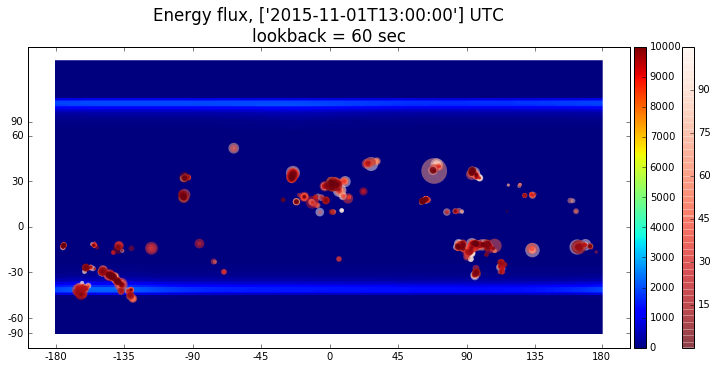

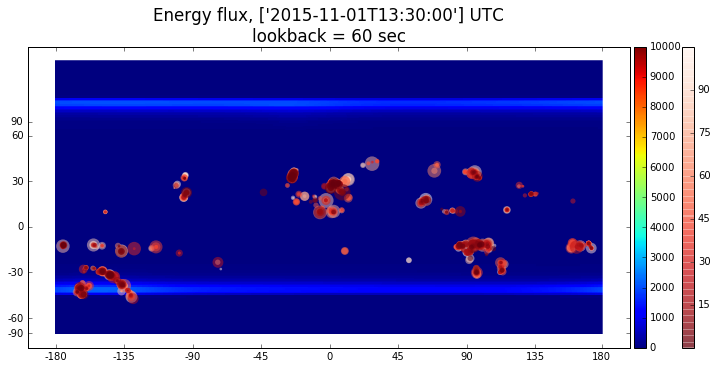

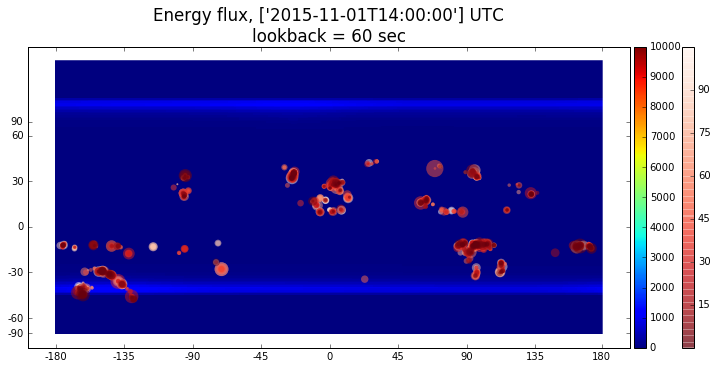

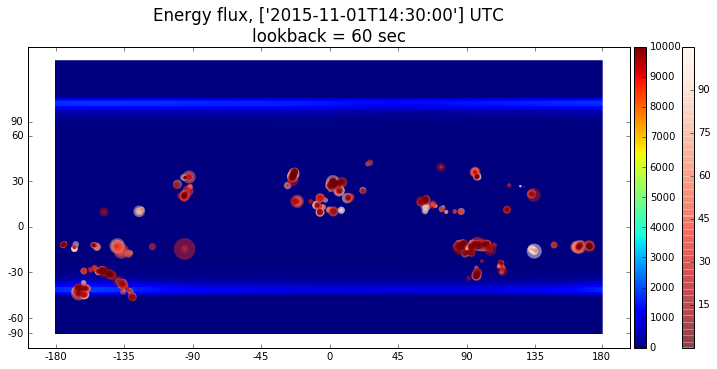

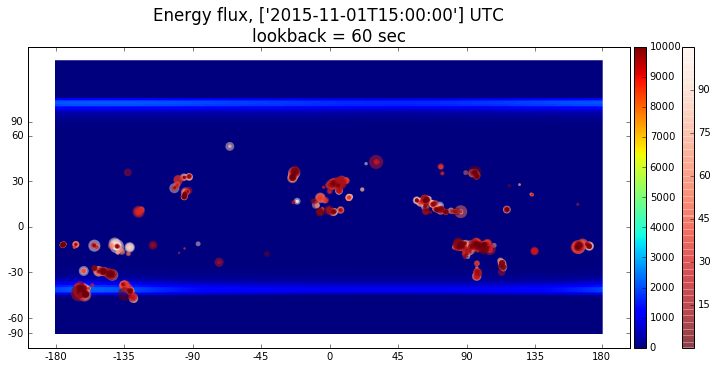

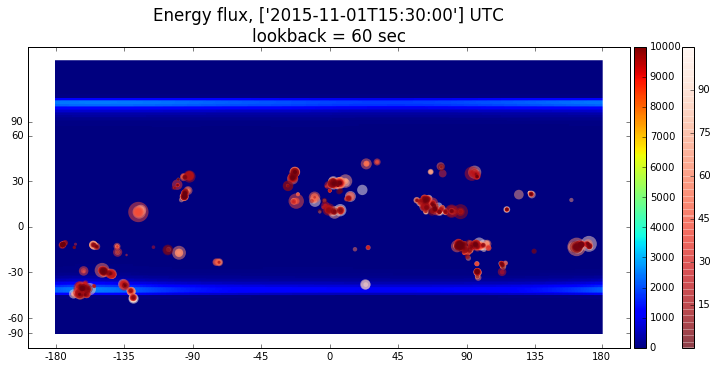

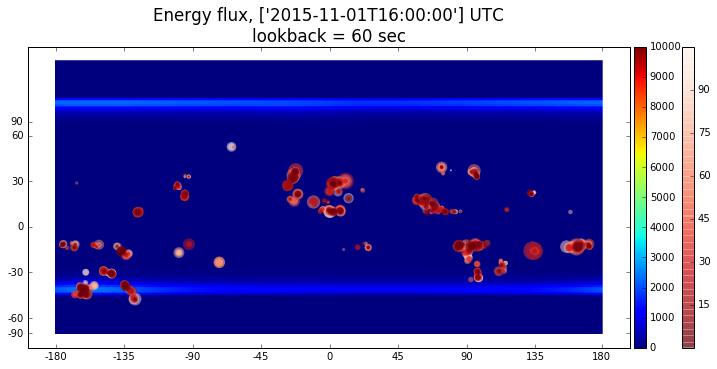

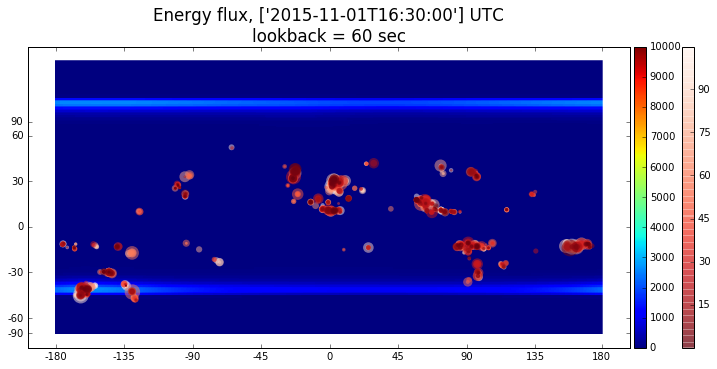

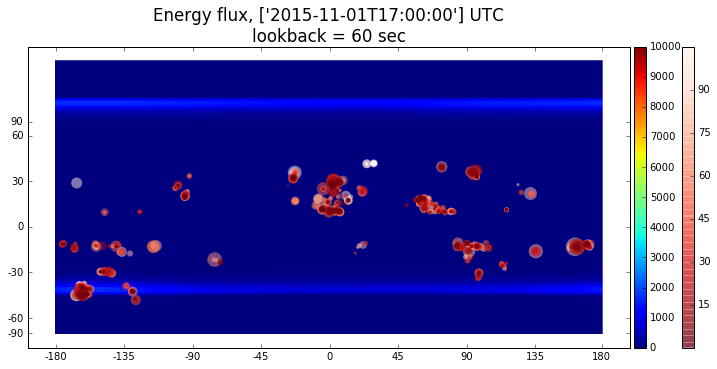

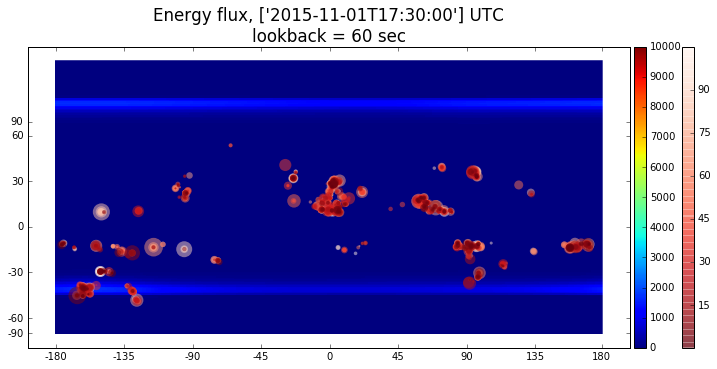

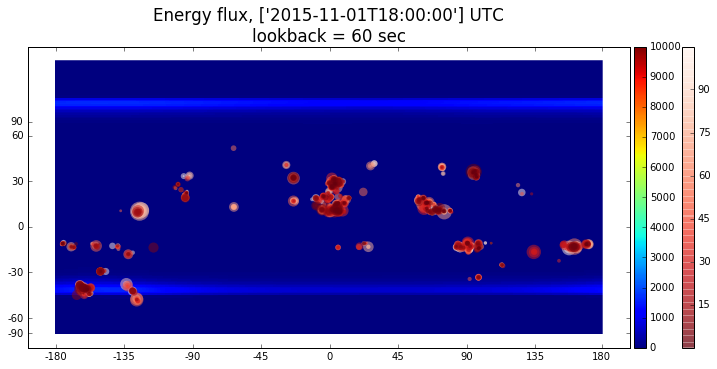

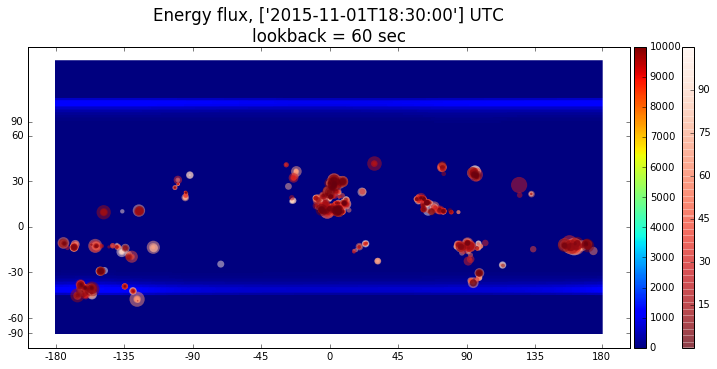

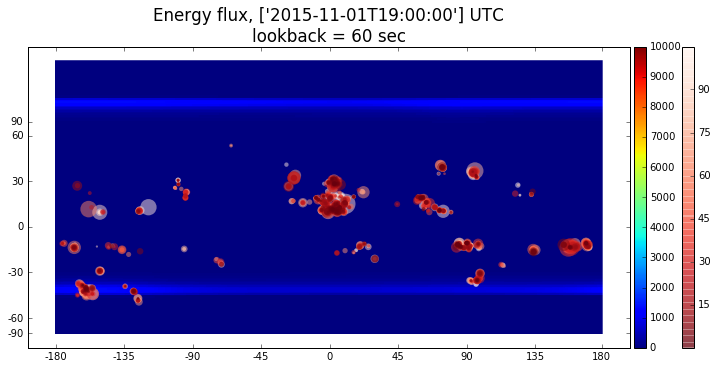

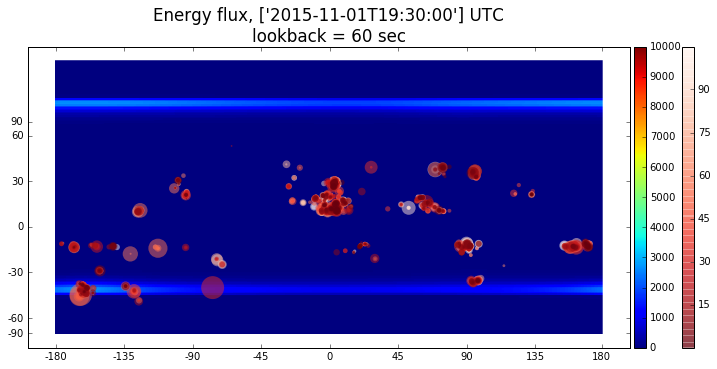

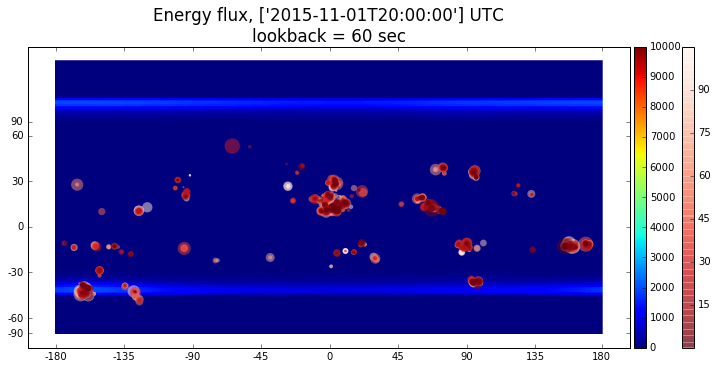

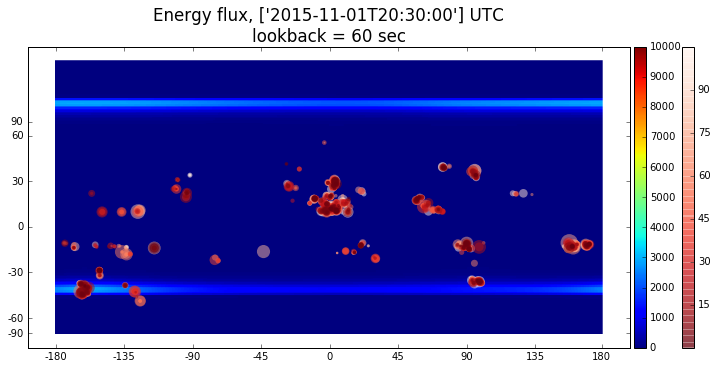

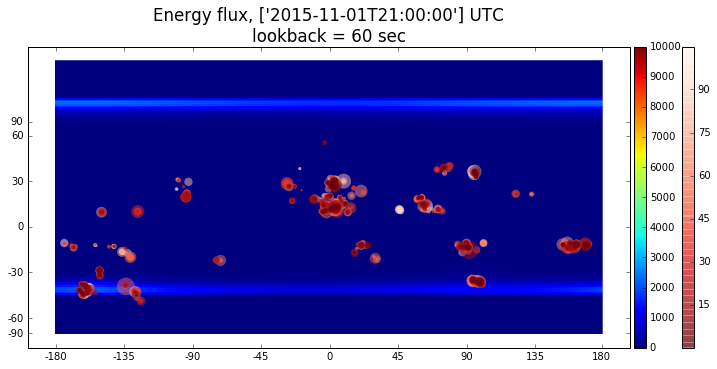

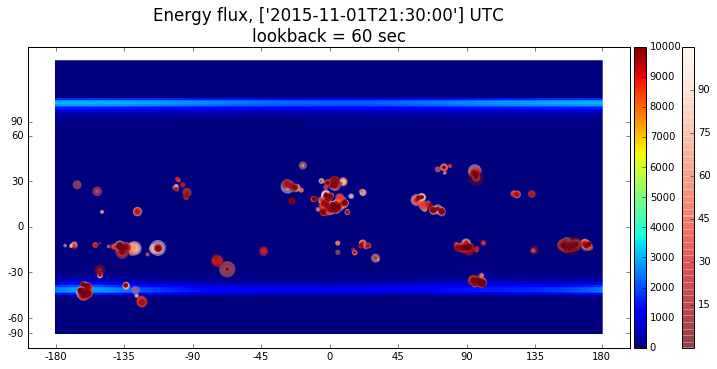

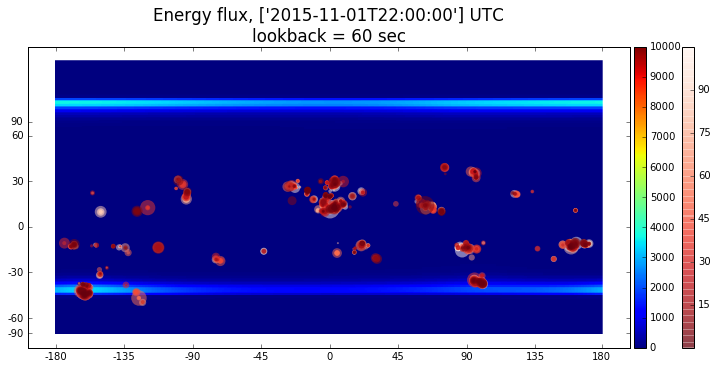

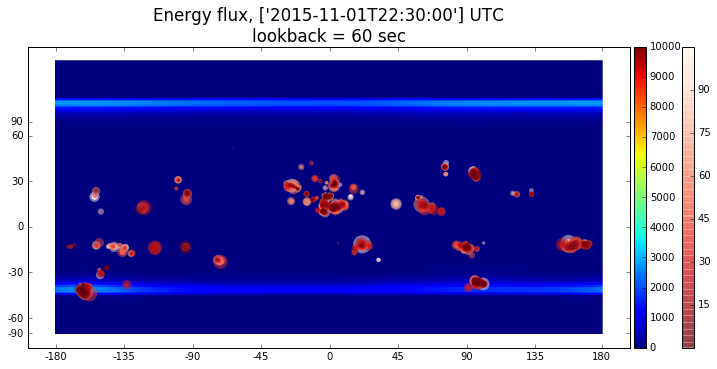

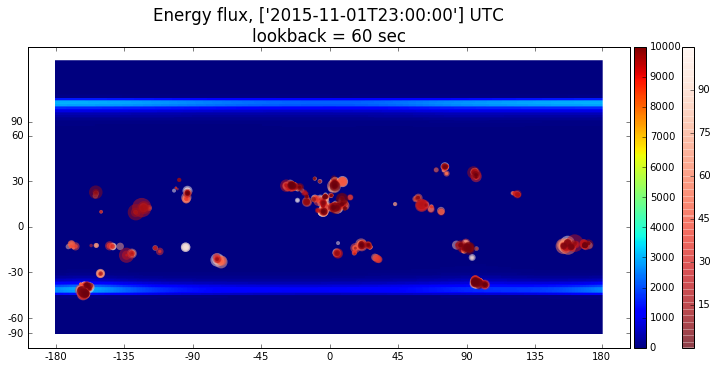

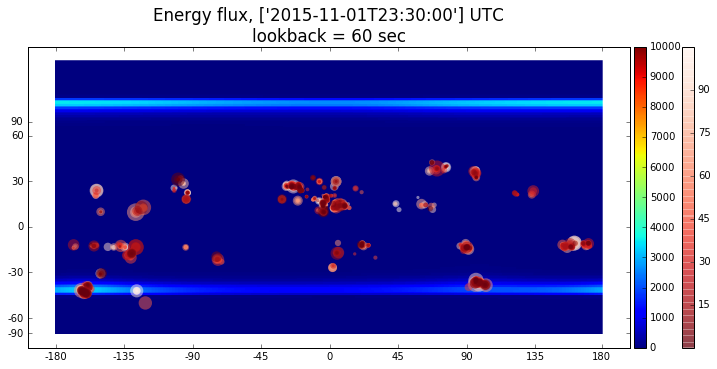

In [247]:
with open('outputs/60sec/dump.pkl','rb') as file:
    recvbuf = pickle.load(file)

# results = []
# [results.extend(r) for r in recvbuf]

print np.shape(recvbuf)

# for job in recvbuf:
for r in recvbuf:
    print r[0]
    if r[2] is not None:
        plt.figure()
        plot_flux_map(r[1], r[2], r[0], clims=[0,10000])
        plt.savefig('outputs/60sec/%s.png'%r[0])

# [tmp.extend(r) for r in recvbuf]




In [126]:
gld = GLD_file_tools('GLD_mount',prefix='GLD' )

flashes, flash_times = gld.load_flashes(in_times[0] - dt.timedelta(seconds=1),dt.timedelta(seconds=2))
print flash_times

[datetime.datetime(2015, 11, 1, 10, 44, 58, 42843)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 49512)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 49521)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 78199)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 81492)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 86995)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 95581)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 101265)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 102810)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 114154)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 117896)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 151471)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 159095)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 162394)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 165544)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 172207)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 175643)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 177801)
 datetime.datetime(2015, 11, 1, 10, 44, 58, 190469)
 datetime.datetime(

In [131]:
np.vstack([np.arange(1,10), (np.arange(15,18))])

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [367]:
flashes, flash_times = gld.load_flashes(dt.datetime(2015,11,1,0,0,0),dt.timedelta(seconds=10))

print flash_times[0]
print flash_times[-1]
print len(flash_times)

section 1
0
0
2015-10-31 23:59:50.031434
2015-10-31 23:59:59.938563
458


In [283]:
dt.datetime(2015,11,1,0,0,0) - dt.timedelta(seconds=1)

datetime.datetime(2015, 10, 31, 23, 59, 59)